# Steel Surface Defect Detection 

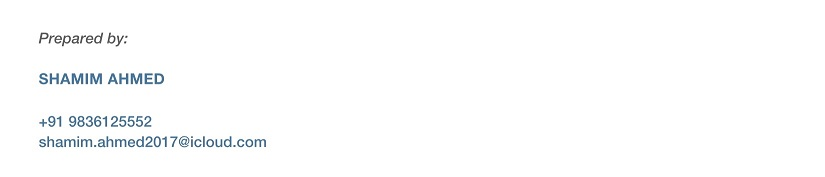

## About the Project

Image recognition and classification is a rapidly growing field in the area of machine learning. Object recognition is a key feature of image classification, and its commercial implications are numerous. We will also comment on the commercial application of this project in the conclusion section. 

## About the Dataset

In the Northeastern University (NEU) surface defect database, six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., 

- rolled-in scale (RS), 
- patches (Pa), 
- crazing (Cr), 
- pitted surface (PS), 
- inclusion (In) and 
- scratches (Sc). 

The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects.The original resolution of each image is 200×200 pixels. 

source: http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html

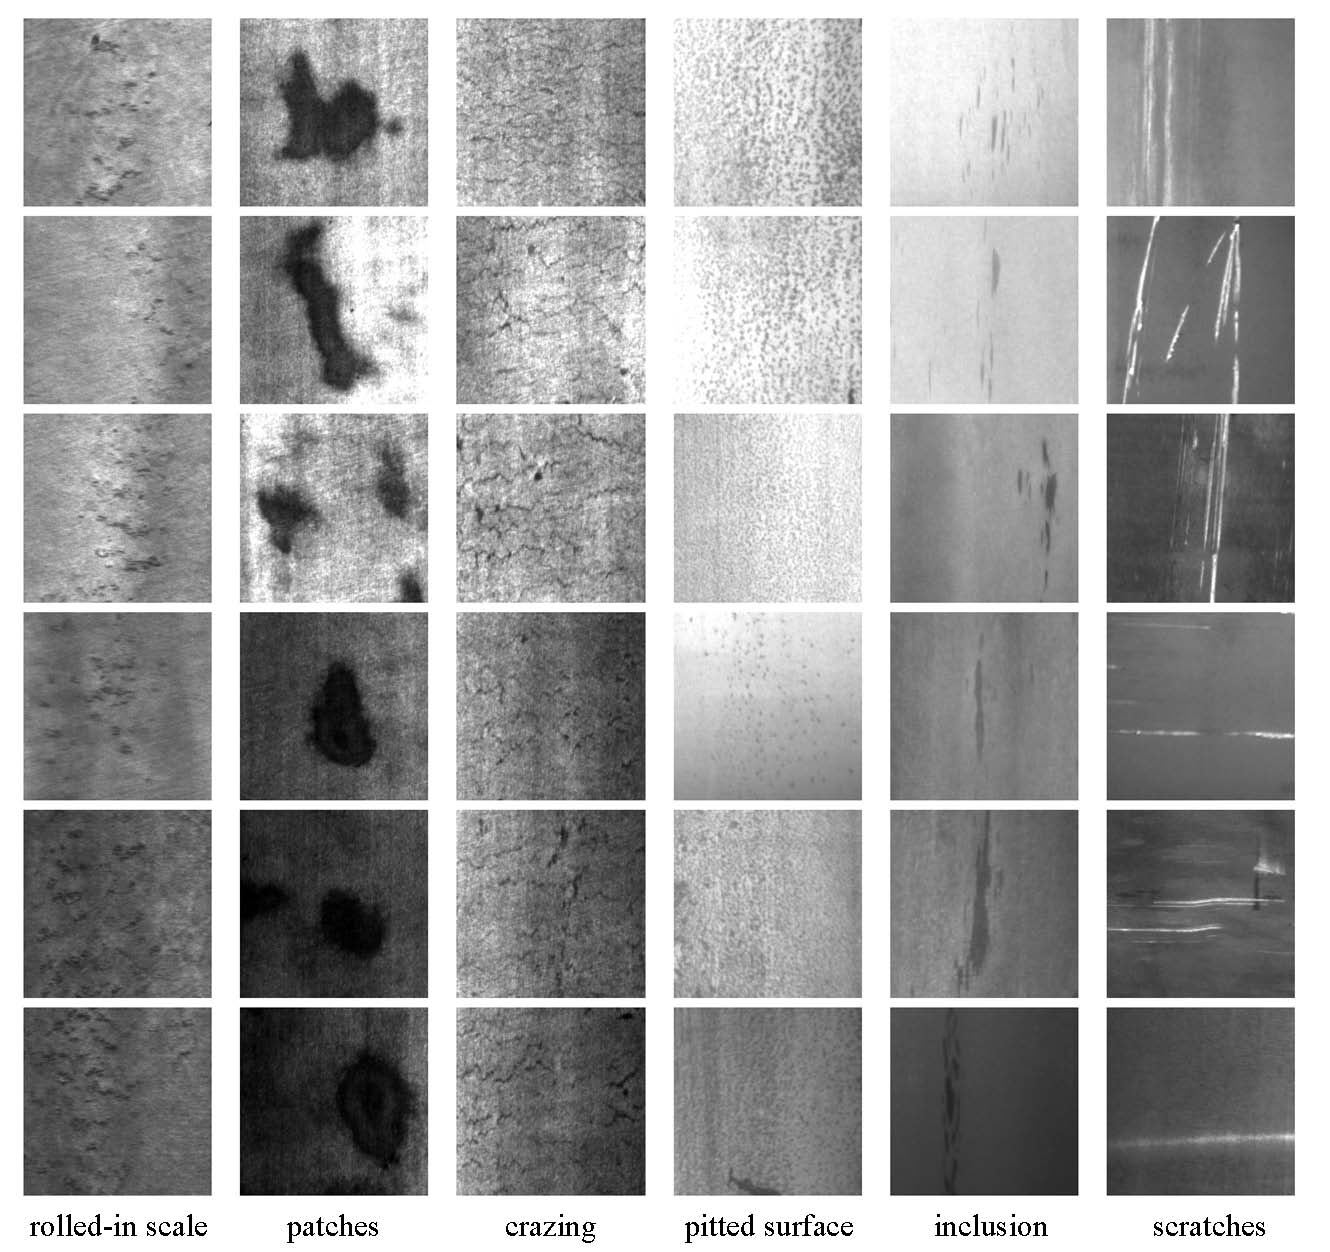

## Our Objective

Using the labelled images, we would use supervised learning techniques to build an Image Classification model using Keras (Tensorflow at the backend). 

After training, the model will be able to classify steel images with similar input size (same resolution) to one of the aforesaid categories, basis image recognition and classification. 

The project has potential to be implemented in Steel Manufacturing lines, for realtime defect detection. 

## GPU check
Image Processing works best on GPU, as it has relatively higher number of cores as compared to CPUs and thus it is prudent to check if the program is using GPU. Below code is for this purpose. 

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14694409163646043037
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3141979340
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7758135298707989609
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Import Libraries

Python language offers us a great advantage with enormous number of 'Libraries' which can be readily used. This reduces the effort of writing codes from scratch and these libraries are extremely powerful and optimized.

We import the requisite libraries that would be used to create our model.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import split_folders

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
from PIL import Image

In [5]:
from tensorflow.keras import models,layers,optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [6]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [7]:
import os
import os.path
import shutil

In [8]:
from tqdm import tqdm
import random

## Set up path for image folders 

The master folder, 'images' has all 1800 images. 
This folder is stored in local drive and the path of this folder is mentioned as 'img_source_dir'.

Firstly, we would split the images into two main folders, 'train_dir' and 'valid_dir' for storing the randomly selected training images and validation images.

Subsequently under each of the 'train_dir' and 'valid_dir' folders, we would create 6 different sub-folders, one folder for each class. The names of these folders will be the same as the names of different classes like, crazing, patches, scratches, etc. 

Kindly note, for commercial use, the images may be stored in servers or databases.

In [9]:
img_source_dir = "F:/Data Science/Python/Python Projects/NEU-DET/images/"
train_dir = "F:/Data Science/Python/Python Projects/NEU-DET/train/"
valid_dir = "F:/Data Science/Python/Python Projects/NEU-DET/valid/"

## Create a function to split the source images into two folders

In [10]:
def split_train_valid (source_dir, train_size):

    images = [file for file in os.listdir(source_dir) 
              if os.path.isfile(os.path.join(source_dir, file))]

    train_counter = 0
    validation_counter = 0
    
    for image in images:
        old_image_path = os.path.join(source_dir, image)

        if random.uniform(0, 1) <= train_size:
            new_image_path = os.path.join(train_dir, image)
            shutil.copy(old_image_path, new_image_path)
            train_counter += 1

        else:
            new_image_path = os.path.join(valid_dir, image)
            shutil.copy(old_image_path, new_image_path)
            train_counter += 1

### Using above function to split source into training & validation image folders

In [11]:
split_train_valid (source_dir = img_source_dir, train_size = 0.8)

## Sort images to multiple folders basis image file name

The file name of individual images are named as class name and serial number, eg. crazing_1, crazing_2, scratches_1, scratches_2, etc. 

We use these file names to group these images in different new sub-folders, one for each class. 
Also the images are moved from the original folders ('train_dir' and 'valid_dir') to the new sub-folders.

We will use these images in the original source folder, 'img_source_dir' for Predictions and visualization of results, which is the most interesting part of the project. The model performance and accuracy of prediction will be made available.

## Create function to sort images to folders with class names

In [12]:
def sort_to_folders (image_dir): 

    images = [file for file in os.listdir(image_dir) 
              if os.path.isfile(os.path.join(image_dir, file))]

    for image in images:
        folder_name = image.split('_')[0]

        new_path = os.path.join(image_dir, folder_name)
        if not os.path.exists(new_path):
            os.makedirs(new_path)

        old_image_path = os.path.join(image_dir, image)
        new_image_path = os.path.join(new_path, image)
        shutil.move(old_image_path, new_image_path)

## Use above function to sort images into respective folders

In [13]:
sort_to_folders (image_dir = train_dir)
sort_to_folders (image_dir = valid_dir)

## Define function to establish image dimensions

The dataset description suggests the resolution of the available images. However we need to verify the image size. This will ensure that the input image size is adequately defined in the model.

We create a function below, to establish the image size of all the images in the master folder.

In [14]:
def image_statistics(image_path):
    heights = []
    widths = []
    img_count = 0
    for img in os.listdir(image_path):
        path = os.path.join(image_path, img)
        if "DS_Store" not in path:
            data = np.array(Image.open(path))
            heights.append(data.shape[0])
            widths.append(data.shape[1])
            img_count += 1
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

## Use function to find out image dimensions

We now apply the function created to our images in the master folder, having all the 1800 images.

In [15]:
image_statistics(image_path = img_source_dir )

Average Height: 200.0
Max Height: 200
Min Height: 200


Average Width: 200.0
Max Width: 200
Min Width: 200


## Set up hyper-parameters for the Convolution Neural Network

Hyper parameters are those parameters used in the model, which can be fine-tuned at our end for optimum results. Some of these parameters are defined by application of best practices, others over multiple iterations and some over past experience.

- image height and width is basis the image dimensions measured above
- training and validation batch size is established after multiple iterations, to ensure that the learning rate is neither skewed, nor too generalized
- The size of feature extractor is taken as (3,3) pixels which is a popular choice; similarly max feature pooling size is taken at (2,2) pixels
- The no. of convolutions taken in the first feature extration is 32, which gradually increases to 256 convolutions
- The number of neurons taken in the deep neural network is 126, almost an average of the input and output layer
- The drop rate of neurons is taken at 50%, after multiple iterations, to ensure the model does not overfit to the training set
- The activation functions at convolution and deep network is 'Rectified Linear Unit (ReLU)' 
- The activation function at the output layer is taken as 'softmax' as we have categorical output classes and softmax helps us to scale the outputs from 0 to 1, which helps us to predict the output class with highest probability
- The no of classes is 6, same as the number of output classes in the dataset
- We will run 500 epochs, basis multiple iterations and observed convergence of loss/error

In [16]:
img_height = 200
img_width = 200

train_batch_size =10
val_batch_size = 25

conv_size = (3,3)
pooling_size = (2,2)

conv1 = 32
conv2 = 64
conv3 = 128
conv4 = 256

density = 126

drop_rate = 0.50

conv_act = 'relu'
hidden_act = 'relu'
output_act = 'softmax'

no_classes = 6
epochs = 500

## Model creation : The heart of the classification model

### The CNN model is built with below sequence of functions:

#### 1. Initialization of sequential model

#### 2. Convolution layers for feature extraction and pooling of max features: 
The convolution layers use filters (nos. as defined) to extract the features of given sets of pixels in an image. Subsequently pooling techniques extracts the elements with maximum values of these features. Max pooling helps to generalize the model, so that the data extracted is not too specific to a section of an image. This activity is done for all the images in the dataset and for each of the pixels.

#### 3. Flattening of convolution layers:
The convolution layers are then flattened to 3-dimension arrays. This form of data can be fed into deep neural network.

#### 4. Deep neural network:
Deep neural network consists of hidden layers and an output layer. 

#### 5. The model is then compiled to put things together

In [17]:
model = Sequential()

model.add(Conv2D(conv1, kernel_size = conv_size, activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=pooling_size))
model.add(BatchNormalization())
model.add(Dropout(drop_rate))

model.add(Conv2D(conv2, kernel_size=conv_size, activation=conv_act))
model.add(MaxPooling2D(pool_size=pooling_size))
model.add(BatchNormalization())
model.add(Dropout(drop_rate))

model.add(Conv2D(conv3, kernel_size=conv_size, activation=conv_act))
model.add(MaxPooling2D(pool_size=pooling_size))
model.add(BatchNormalization())
model.add(Dropout(drop_rate))

model.add(Conv2D(conv4, kernel_size=conv_size, activation=conv_act))
model.add(MaxPooling2D(pool_size=pooling_size))
model.add(BatchNormalization())
model.add(Dropout(drop_rate))


model.add(Flatten())
model.add(Dense(density, activation=hidden_act))
model.add(Dropout(drop_rate))
model.add(Dense(density, activation=hidden_act))
model.add(Dropout(drop_rate))
model.add(Dense(density, activation=hidden_act))
model.add(Dropout(drop_rate))
model.add(Dense(density, activation=hidden_act))
model.add(Dropout(drop_rate))

model.add(Dense(no_classes, activation = output_act))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 99, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________

## Image Data augmentation and Pre-processing

#### a. 'train_datagen' and 'test_datagen' (as named) are used for data augmentation, namely:

- rescaling of dataset in the range of 0-255 (as we have 256 shades/values of a pixel)
- adjusting the shear and zoom range
- flipping of images

The first technique is applicable for both train and test dataset, while the rest two are applicable only for training dataset. 


#### b. 'train_generator' and 'validation_generator' (as named) are used to create datasets using the image folders (sub-folders created for each class)

- 1429 images corresponds to the training set (80%)
- 371 images corresponds to the validation set (20%)

The training images will be used to train the model over multiple iterations.

Further the validation images will be used to instantly test the accuracy of model on these sample images

In [18]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=train_batch_size,
        class_mode='categorical',
        seed=777,
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(img_height, img_width),
        batch_size=val_batch_size,
        class_mode='categorical',
        seed=777,
        shuffle=True)

Found 1436 images belonging to 6 classes.
Found 364 images belonging to 6 classes.


## Fitting the model

The model created above will be fitted to the training set of images. In this process the model will be trained to identify image features and subsequently will be able to classify images with similar size and classes.

The batch size is taken as 10 images ie. 10 images will be taken at a time to align the weights of the model. The number of steps will be 142 to cover ~1420 images. This cycle completes 1 epoch.

Similarly 500 such epochs are programmed to ensure that the model is trained well against the dataset over multiple iterations and adjustment of weights to arrive at an acceptable low error/cost.

In [19]:
step_train = train_generator.n//train_generator.batch_size
step_valid = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(generator = train_generator,
                    steps_per_epoch = step_train,
                    validation_data = validation_generator,
                    validation_steps = step_valid,
                    epochs=epochs,
                    verbose=0)

**The value of verbose is kept as '0'.
In case the value is changed to '1', we could see the epochs in action.**

**It would show us the Training and Validation accuracies and errors after each epoch. In any case, the accuracies and errors against the number of epochs have been plotted below.**

## Plotting the loss curves

Text(0.5, 1.0, 'Loss Curves')

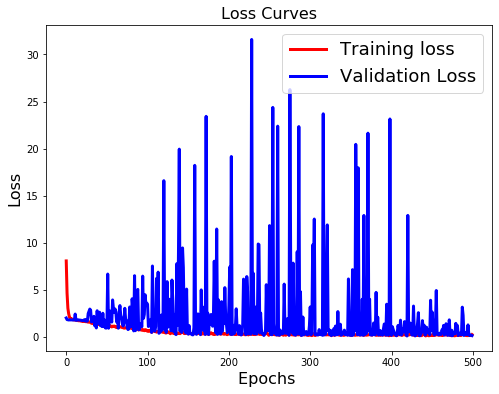

In [20]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

**The training and validation error gradually declines with higher number of epochs**

## Plotting the accuracy curves

Text(0.5, 1.0, 'Accuracy Curves')

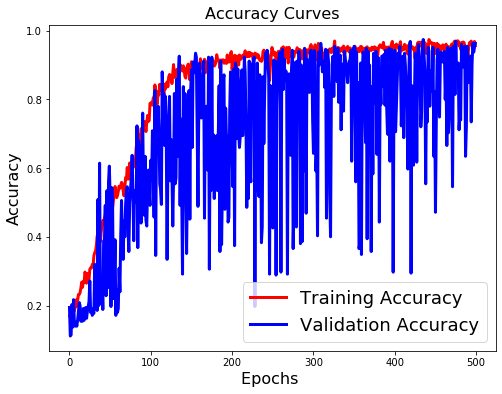

In [21]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

**The training and validation accuracies gradually move up the curve consistently over multiple iterations**

## Save model for further use

In [22]:
model.save('model.h1')

## Compile the saved model for re-use

In [23]:
from tensorflow.keras.models import load_model 

model = load_model('model.h1')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Creating a list of all images from the master folder with 1800 images

In [24]:
image_name = os.listdir(img_source_dir)

## Preprocessing images for the purpose of predictions (1800 images)

In [31]:
images = []

for img in os.listdir(img_source_dir):
    img = os.path.join(img_source_dir, img)
    img = tf.keras.preprocessing.image.load_img(img, target_size=(img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    images.append(img)

In [32]:
# stack up images list to pass for prediction
images = np.vstack(images)
images.shape

(1800, 200, 200, 3)

## Making predictions using the model and the proprocessed image list 

In [33]:
predictions = model.predict(images)
y_pred = [np.argmax(probas) for probas in predictions]

# Visualization of Predictions

## Select random sample index nos. of the predicted results

In [37]:
random_list=[]
n=25

for i in range(n):
    random_list.append(random.randint(0, len(y_pred)))

print("The Randomly selected Index of predictions are:", random_list)

The Randomly selected Index of predictions are: [1029, 475, 1578, 1554, 1138, 1375, 1081, 512, 135, 1196, 1747, 1553, 771, 304, 684, 1784, 897, 19, 932, 984, 989, 543, 258, 1347, 1626]


## Create function to visualize randomly selected images

In [38]:
def visualize_prediction():
    for i in range(len(random_list)):
        a = random_list[i]
        plt.figure() 
        title =''
        if y_pred[a] == 0: 
            title='Prediction: crazing'
        elif y_pred[a] == 1: 
            title='Prediction: inclusion'
        elif y_pred[a] == 2: 
            title='Prediction: patches'
        elif y_pred[a] == 3: 
            title='Prediction: pitted'
        elif y_pred[a] == 4: 
            title='Prediction: rolled-in'
        elif y_pred[a] == 5: 
            title='Prediction: scratches' 
        plt.title(title)
        plt.imshow(images[a])
        plt.xlabel(image_name[a])

## Use above function to visualize images with file name & predictions

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


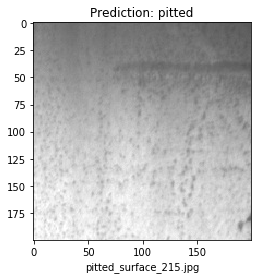

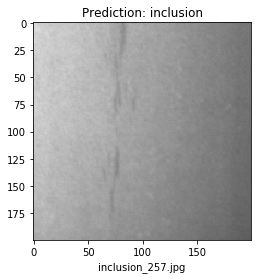

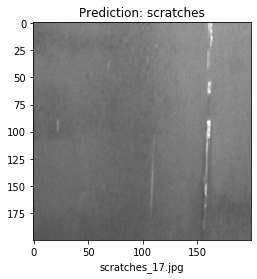

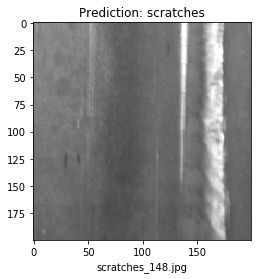

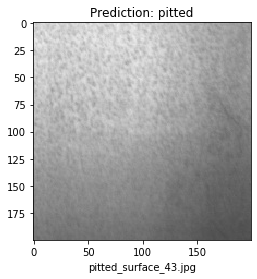

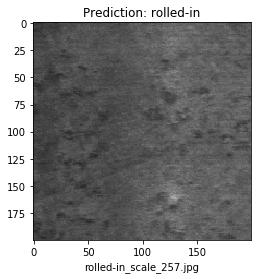

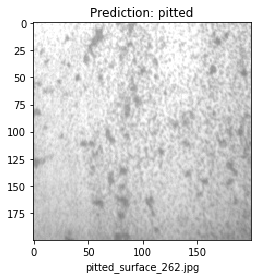

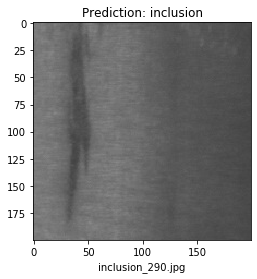

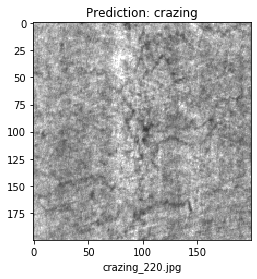

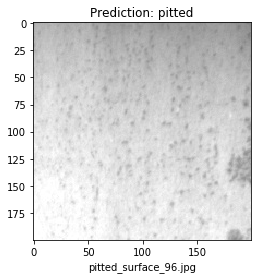

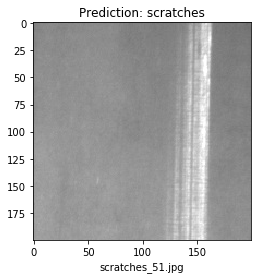

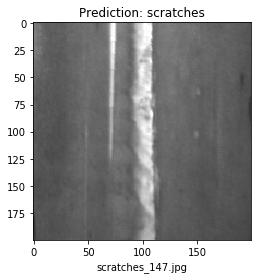

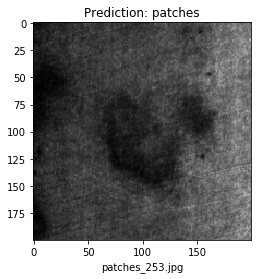

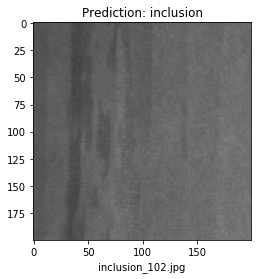

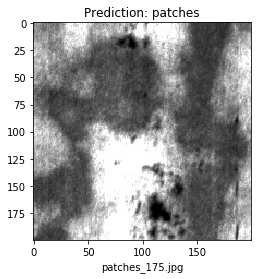

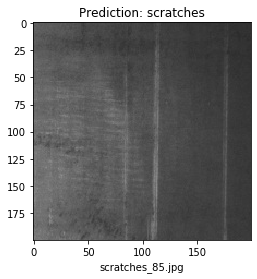

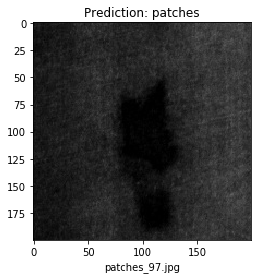

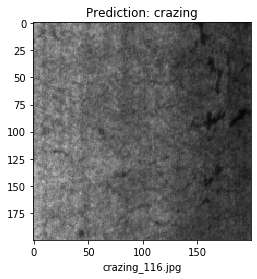

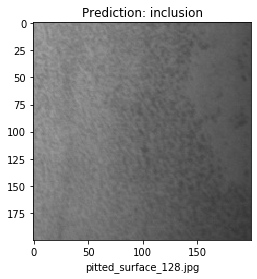

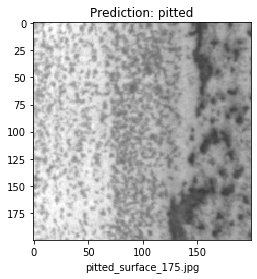

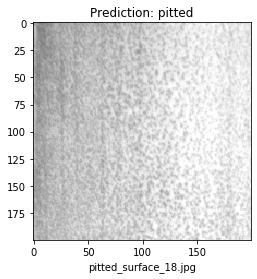

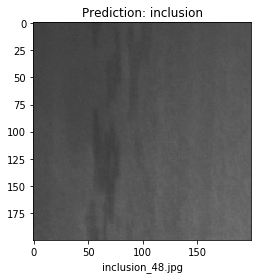

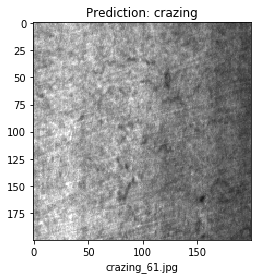

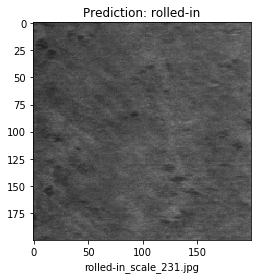

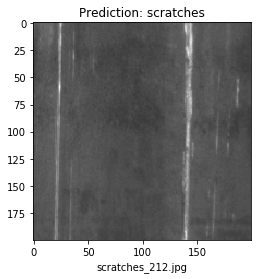

In [39]:
visualize_prediction()

## Conclusion

This model is created basis a small set of 1800 images. The results are fairly accurate though. 
The concept can be replicated by Iron and Steel manufacturing companies on their production lines, with below considerations:

- The image size may vary. The project uses 200 by 200 pixels images. In production lines though, higher resolution images may be used which ofcourse would require higher hardware capabilities to process large images
- An existing large database of images with labelled classification would be required to originally train the model and measure its accuracy against a separate set of images with similar size and classes.
- The above mentioned image dataset to be used for training the model by plant should ideally have images with no defects as well. Such images would be labelled suitably eg. 'No Defect'.
- Setup needs to be done for installation of a high resolution camaera, and an integrated printing machine. The soft copy of the steel image and the actual sheet needs to bear the same label for identifying and locating the sheet with defects. 
- The model in the project is limited to classification of images basis defects, however the model can further be developed for encoding the location of the defect as well, which would make more sense as it would help the team at plant to identify the exact location of the defect with ease. 


#### The following are obvious benefits of the setup, which can be availed by the company:
- Increased accuracy for identificaion of defects, as compared to physical inspection.
- Reducing manpower cost for physical inspection
- Client satisfaction, as defect in steel will be identified at plant level with higher accuracies and will not be dispatched to client
- Saving of logistics cost, which otherwise would be incurred for to and fro movement of defect materials from plant to client destination
- The data can be used for R&D to reduce the instances of manufacturing defects